In [13]:
import nbformat
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import GridSearchCV
import keras_tuner
import keras

In [14]:
%run 'one_hot.ipynb'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [15]:
fasta_file = os.path.join('..','repertoire','bigger','bigger_10000.fasta')
sequences = input_file(fasta_file)
chunk_size = 450
X = process_input(sequences, chunk_size)
annotation_file = os.path.join('..','repertoire','bigger','bigger_10000.tsv')
df = pd.read_csv(annotation_file, sep='\t', header=0)
y,y_class = process_output(df)

/tmp/ipykernel_519835/3505619144.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)
/tmp/ipykernel_519835/2970507474.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(seq, np.int8)
/tmp/ipykernel_519835/3818073805.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  seq_array = np.fromstring(seq, np.int8)


In [16]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        print("GPU device:", gpu)
        print("number of GPU device: ",len(tf.config.experimental.list_physical_devices('GPU')))
else:
    print("No GPU devices found.")


tf.config.experimental.set_memory_growth(gpus[0], True)

GPU device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
number of GPU device:  1


In [33]:
def call_existing_code(units, activation, dropout, lr, filters):
    
    # parameters of input shape
    sequence_length = 450
    one_hot_length = 5
    input_shape = (sequence_length, one_hot_length)
    
    # create the model
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=2, padding='same', activation='relu', input_shape=input_shape))
    if dropout:
        model.add(Dropout(0.5))
    model.add(Conv1D(filters=filters, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Dense(units=units, activation=activation))
    if dropout:
        model.add(Dropout(0.5))
    model.add(Dense(450*5, activation='softmax'))
    model.add(Reshape((450,5)))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [36]:
def create_model(hp):
 
    #hyperparameter
    filters = hp.Int("filters", min_value=8, max_value=64, step=8)
    units = hp.Int("units", min_value=32, max_value=128, step=32)
    activation = hp.Choice("activation",["relu","tanh"])
    dropout = hp.Boolean("dropout")
    lr=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    #build the model
    model = call_existing_code(
        units=units, activation=activation, dropout=dropout, lr=lr, filters=filters
    )
   
    return model

In [37]:
create_model(keras_tuner.HyperParameters())

In [38]:
tuner = keras_tuner.RandomSearch(
    hypermodel=create_model,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=3,
    overwrite=True,
    directory="output",
    project_name="VDJ"
)

In [39]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
filters (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [40]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [42]:
tuner.search(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

INFO:tensorflow:Oracle triggered exit


In [43]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 28, 28))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 450, 64)           704       
                                                                 
 conv1d_1 (Conv1D)           (None, 450, 64)           8256      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 450, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 96)                2764896   
                                                                 
 dense_1 (Dense)             (None, 2250)              218250    
                                                        

In [44]:
tuner.results_summary()

Results summary
Results in output/VDJ
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 12 summary
Hyperparameters:
filters: 64
units: 96
activation: relu
dropout: False
lr: 0.0012513458296776205
Score: 0.9877585172653198

Trial 09 summary
Hyperparameters:
filters: 64
units: 96
activation: relu
dropout: False
lr: 0.003378131836989523
Score: 0.987045427163442

Trial 01 summary
Hyperparameters:
filters: 16
units: 64
activation: relu
dropout: False
lr: 0.003072821882297506
Score: 0.9865214824676514

Trial 15 summary
Hyperparameters:
filters: 32
units: 32
activation: relu
dropout: False
lr: 0.0029533922569706128
Score: 0.9865204890569051

Trial 11 summary
Hyperparameters:
filters: 16
units: 96
activation: tanh
dropout: False
lr: 0.0029860644714577917
Score: 0.9855698744455973

Trial 10 summary
Hyperparameters:
filters: 32
units: 128
activation: relu
dropout: True
lr: 0.002647525297275649
Score: 0.9812301198641459

Trial 17 summary
Hyperparameters:
filters: 56
un

In [56]:
import time
import keras
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [51]:
sequence_length = chunk_size
one_hot_length = 5
input_shape = (sequence_length, one_hot_length)
num_classes = 5

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=input_shape))


model.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=1))

model.add(Flatten())
model.add(Dense(96, activation='relu', kernel_initializer='he_normal'))

model.add(Dense(450*5, activation='softmax'))
model.add(Reshape((450,5)))
model.compile(loss='categorical_crossentropy', optimizer= Adam(learning_rate=0.0012513458296776205), metrics=['accuracy'])
print(model.summary())

start_time = time.time()
log_dir = "logs/CNNonshm/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tf_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3)
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=30, batch_size=32, callbacks=[tf_callback])
end_time = time.time()
training_time = end_time - start_time
print("Training the model took {:.2f} seconds".format(training_time))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 450, 64)           704       
                                                                 
 conv1d_12 (Conv1D)          (None, 450, 64)           8256      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 450, 64)          0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 28800)             0         
                                                                 
 dense_10 (Dense)            (None, 96)                2764896   
                                                                 
 dense_11 (Dense)            (None, 2250)              218250    
                                                      

In [53]:
y_pred = model.predict(X_test)
pred_classes = np.argmax(y_pred, axis=-1)

94/94 [==============================] - 0s 488us/step


In [54]:
y_true = np.argmax(y_test,axis=-1)

In [58]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

([<matplotlib.axis.YTick at 0x7fc7e573fe50>,
 [Text(0, 0.5, 'V'),
  Text(0, 1.5, 'D'),
  Text(0, 2.5, 'J'),
  Text(0, 3.5, 'N'),
  Text(0, 4.5, 'X')])

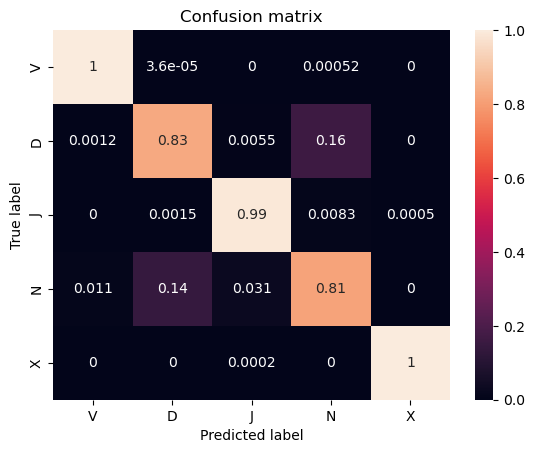

In [59]:
y_true_flat = y_true.flatten()
y_pred_flat = pred_classes.flatten()
cm = confusion_matrix(y_true_flat,y_pred_flat)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=['V', 'D', 'J', 'N', 'X'])
labels = ['V', 'D', 'J', 'N', 'X']
plt.xticks(np.arange(5) + 0.5, labels)
plt.yticks(np.arange(5) + 0.5, labels)

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

In [63]:
# accuracy
accuracy = accuracy_score(y_true_flat, y_pred_flat)
print('Accuracy:', accuracy)

# precision
precision = precision_score(y_true_flat, y_pred_flat, average='macro')
print('Precision:', precision)

# recall
recall = recall_score(y_true_flat, y_pred_flat, average='macro')
print('Recall:', recall)

# F1-score
f1 = f1_score(y_true_flat, y_pred_flat, average='macro')
print('F1 Score:', f1)

Accuracy: 0.9876592592592592
Precision: 0.9266639633068877
Recall: 0.9268696307041744
F1 Score: 0.9266998376928164


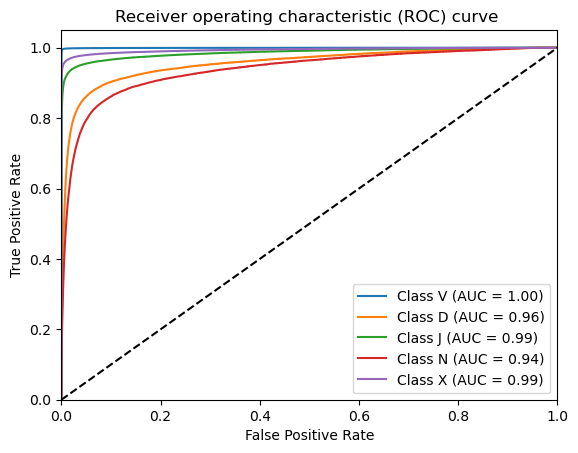

In [66]:
vdjclass = ["V","D","J","N","X"]
plt.figure()
for i in range(5):
    y_pred_1d = y_pred[:,:,i].ravel()
    y_true_1d = y_test[:,:,i].ravel()
    fpr, tpr, _ = roc_curve(y_true_1d, y_pred_1d)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label='Class %s (AUC = %0.2f)' % (vdjclass[i],roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve ')
plt.legend(loc="lower right")
plt.show()